# <center>Text clustering with KMeans algorithm using scikit learn</center>

There are many clustering algorithms for clustering including **KMeans, DBSCAN, Spectral clustering, hierarchical clustering etc.** and they have their own advantages and disadvantages. 

The choice of the algorithm mainly depends on **whether or not you already know how many clusters to create**. 

Some algorithms such as KMeans need you to specify number of clusters to create whereas DBSCAN does not need you to specify. 

Another consideration is whether you need the trained model to able to predict cluster for unseen dataset. **KMeans can be used to predict the clusters for new dataset whereas DBSCAN cannot be used for new dataset**.

## 1. Load data

In this experiment we’ll cluster news articles into different categories. 

First download the dataset from the below link and extract:

https://github.com/zhangjianzhang/text_mining/blob/master/files/codes/lecture_8/bbc-fulltext.zip?raw=true

The dataset consists of 2225 documents and 5 categories: business, entertainment, politics, sport, and tech. 

For most part, we'll ignore the labels but we'll use them while evaluating the trained model since many of the evaluation metrics need the "true" labels.

In [1]:
# import required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Now we can read the data. If you look at the extracted zip, you'll see there are 5 folders each containing articles. 

Each folder indicates a category and the articles contained in that folder belong to that category. 

To load data in this kind of format, sklearn has easy utility function called `load_files` which load text files with categories as subfolder names.

In [2]:
from sklearn.datasets import load_files

# for reproducibility
random_state = 100 

DATA_DIR = "./bbc/"
data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace", random_state=random_state)

In [3]:
type(data.target_names)

list

In [4]:
data.target_names

['business', 'entertainment', 'politics', 'sport', 'tech']

In [5]:
type(data.data)

list

In [6]:
len(data.data)

2225

In [7]:
print(data.data[0])

US woman sues over ink cartridges

A US woman is suing Hewlett Packard (HP), saying its printer ink cartridges are secretly programmed to expire on a certain date.

The unnamed woman from Georgia says that a chip inside the cartridge tells the printer that it needs re-filling even when it does not. The lawsuit seeks to represent anyone in the US who has purchased an HP inkjet printer since February 2001. HP, the world's biggest printer firm, declined to comment on the lawsuit. HP ink cartridges use a chip technology to sense when they are low on ink and advise the user to make a change.

But the suit claims the chips also shut down the cartridges at a predetermined date regardless of whether they are empty. "The smart chip is dually engineered to prematurely register ink depletion and to render a cartridge unusable through the use of a built-in expiration date that is not revealed to the consumer," the suit said. The lawsuit is asking for restitution, damages and other compensation. Th

In [8]:
print(data.data[1])

EU software patent law delayed

Controversial new EU rules for the patenting of computer-based inventions have been put on hold due to a last minute intervention from Poland.

Poland - a large and therefore crucial EU member - has requested more time to consider the issue, especially as it relates to the patenting of software. Critics say the law would favour large companies over small, innovative ones. They say it could have massive ramifications for developments such as open source software.

Polish ministers want to see the phrasing of the text of the Directive on the Patentability of Computer-Implemented Inventions changed so that it excludes the patenting of software. The planned law has ignited angry debate about whether the EU should allow the patenting of computer programs and internet business methods as currently happens in the US. So, for instance, US-based Amazon.com holds a patent on 'one-click shopping'. Critics claim the law, which the EU says is needed to harmonise with

In [9]:
type(data.target)

numpy.ndarray

In [10]:
len(data.target)

2225

In [11]:
print(data.target[:2])

[4 4]


In [12]:
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df.head()

,text,label
0,US woman sues over ink cartridges\n\nA US woma...,4
1,EU software patent law delayed\n\nControversia...,4
2,Robben plays down European return\n\nInjured C...,3
3,US regulator to rule on pain drug\n\nUS food a...,0
4,Edwards tips Idowu for Euro gold\n\nWorld outd...,3


## 2. Feature extraction

For each article in our dataset, we’ll compute TF-IDF values.

In [13]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.text.values)
features = vec.transform(df.text.values)

Now we have our feature matrix, we can feed to the model for training.

## 3. Model training

Let's create an instance of KMeans. I'll choose 5 as the number of clusters since the dataset contains articles that belong to one of 5 categories.

Obviously, if you do not have labels then you won't exactly know how many clusters to create so you have to find the best one that fits your needs via **running multiple experiements and using domain knowledge to guide you**.

In [14]:
cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(n_clusters=5, random_state=100)

In [15]:
# For more information about the usage of MiniBatchKMeans, see the documentation as follow (uncomment the below code):
# help(MiniBatchKMeans)

That is all it takes to create and train a clustering model. Now to predict the clusters, we can call `predict` function of the model.

Note that not all clustering algorithms can predit on new datasets. In that case, you can get the cluster labels of the data that you used when calling the fit function using `labels_` attribute of the model.

In [16]:
# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([2, 2, 0, ..., 2, 2, 0], dtype=int32)

In [17]:
type(cls.cluster_centers_)

numpy.ndarray

In [18]:
cls.cluster_centers_.shape

(5, 29126)

## 4. Visualization

To visualize, we’ll plot the features in a 2D space. 

As we know the dimension of features that we obtained from TfIdfVectorizer is quite large ( > 10,000), we need to reduce the dimension before we can plot. For this, we’ll ues **PCA** to transform our high dimensional features into 2 dimensions.

In [19]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

In [20]:
reduced_features.shape

(2225, 2)

Now that we have reduced our features and cluster centers into 2D, we can plot those points using a scatter plot. 

The first dimension will be used as X values and second dimension will be used as Y values in a X-Y plot. 

We also assign colors to each items using the predicted cluster labels so that items in a same cluster will be represented with same color. 

This is done by passing the labels to `c` parameter in `scatter` function. 

Again, if the clustering algorithm does not support predict function or if you want to visualize in the training data itself, you can also use `c = cls.labels_` instead.

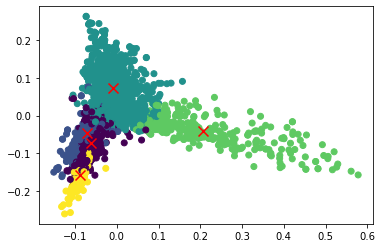

In [21]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=100, c='r')

From the plot below we can see that apart from the rightmost two clusters, items of other three clusters seem to be scattered all around and overlapping as well.

## 5. Evaluation

Evaluation for unsupervised learning algorithms is **a bit difficult and requires human judgement** but there are some metrics which you might use. 

There are two kinds of metrics you can use **depending on whether or not you have the labels**. For most of the clustering problems, you probably won’t have labels.

### 5.1 Evalauation with labelled dataset

If you have labelled dataset then you can use few metrics that give you an idea of how good your clustering model is. 

The one I’m going to show you here is **homogeneity_score** but you can find and read about many other metrics in `sklearn.metrics` module. 

The score ranges between 0 and 1 where 1 stands for perfectly homogeneous labeling.

In [22]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df.label, cls.predict(features))

0.5156703649915512

### 5.2 Evaluation with unlabelled dataset

If you don't have labels for your dataset, then you can still evaluate your clustering model with some metrics. One of them is **Silhouette Coefficient**.

The best value is 1 and the worst value is -1. 

Values near 0 indicate overlapping clusters. 

Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [23]:
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.009190345442346363

So this value means that our clusters are overlapping. We can also see this in the plot above. Perhaps tuning different parameters for feature extractor and the clustering model will increase this score.

## 6. Conclusion

This experiment showed you how to cluster text using KMeans algorithm. You can cluster any kind of data, not just text and can be used for wide variety of problems. While the evaluation of clustering algorithms is not as easy compared to supervised learning models, it is still desirable to get an idea of how your model is performing. However, it is important to know what the metrics are measuring and if they are biased or have any limitations.

<font size=2 style="color:#BA4A00">**练习**</font>

1. 请将上面使用的数据按照9:1进行划分训练集和测试集合，重复上述实验；

2. 使用20newsgroup数据集（可以只使用一部分）进行实验，计算不同K值（类簇数量）对应的聚类评价指标的值，如homogeneity_score，Silhouette Coefficient，或者其他指标，通过多次实验（可以绘制折线图），找出一个最优的K值，scikit-learn内置了20newsgroup数据集，可参考lecture_7的代码导入该数据集；

3. 通过互联网查找学习聚类结果评价指标，可参考scikit-learn文档中的示例进行学习:
https://scikit-learn.org/stable/modules/classes.html#clustering-metrics